In [1]:
import random
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.pipeline import Pipeline

import raimitigations.dataprocessing as dp
from raimitigations.cohort import CohortDefinition, CohortManager

SEED = 42

In [2]:
def create_df(with_null: bool = True):
    np.random.seed(SEED)
    random.seed(SEED)
    def add_nan(vec, pct):
        vec = list(vec)
        nan_index = random.sample(range(len(vec)), int(pct * len(vec)))
        for index in nan_index:
            vec[index] = np.nan
        return vec

    df = dp.create_dummy_dataset(
        samples=1000,
        n_features=2,
        n_num_num=0,
        n_cat_num=2,
        n_cat_cat=0,
        num_num_noise=[0.01, 0.05],
        pct_change=[0.05, 0.1],
    )
    if with_null:
        col_with_nan = ["num_0", "num_1", "CN_0_num_0"]
        for col in col_with_nan:
            if col != "label":
                df[col] = add_nan(df[col], 0.1)

    X = df.drop(columns=["label"])
    y = df[["label"]]

    return X, y

# -----------------------------------
def get_model():
    model = xgb.XGBClassifier(
            objective="binary:logistic",
            learning_rate=0.1,
            n_estimators=30,
            max_depth=10,
            colsample_bytree=0.7,
            alpha=0.0,
            reg_lambda=10.0,
            nthreads=4,
            verbosity=0,
            use_label_encoder=False,
        )
    return model

In [3]:
X, y = create_df()
X

,num_0,num_1,CN_0_num_0,CN_1_num_1
0,1.601034,2.535353,val0_0,val1_3
1,1.755945,-2.172352,val0_1,val1_0
2,2.354479,NaN,val0_0,val1_0
3,4.103090,-0.766515,NaN,val1_2
4,1.753178,1.787514,val0_0,val1_1
...,...,...,...,...
995,2.713939,1.451639,val0_1,val1_2
996,1.420812,2.535627,val0_0,val1_3
997,3.844315,1.211294,val0_1,val1_2
998,0.974124,2.619258,val0_0,val1_3


In [4]:
cohort_pipeline = [
    dp.BasicImputer(verbose=False),
    dp.DataMinMaxScaler(verbose=False),
]

c1 = [ ['CN_0_num_0', '==', 'val0_1'], 'and', ['num_0', '>', 0.0] ]
c2 = [ ['CN_0_num_0', '==', 'val0_0'], 'and', ['num_0', '>', 0.0] ]
c3 = None

cohort_set = CohortManager(
    transform_pipe=cohort_pipeline,
    cohort_def=[c1, c2, c3]
)
cohort_set.fit(X=X, y=y)
new_X = cohort_set.transform(X)
new_X

,num_0,num_1,CN_0_num_0,CN_1_num_1
0,0.644404,0.790075,val0_0,val1_3
1,0.358006,0.040024,val0_1,val1_0
2,0.951876,0.664130,val0_0,val1_0
3,0.854076,0.377636,NULL,val1_2
4,0.706492,0.688320,val0_0,val1_1
...,...,...,...,...
995,0.561783,0.669115,val0_1,val1_2
996,0.570857,0.790112,val0_0,val1_3
997,0.802227,0.627393,val0_1,val1_2
998,0.388569,0.801491,val0_0,val1_3


In [5]:
cohort_pipeline = [
    dp.BasicImputer(verbose=False),
    dp.DataMinMaxScaler(verbose=False),
    dp.EncoderOrdinal(verbose=False),
    get_model()
]

cohort_set = CohortManager(
    transform_pipe=cohort_pipeline,
    cohort_def=[c1, c2, c3]
)
cohort_set.fit(X=X, y=y)
new_X = cohort_set.transform(X)

In [6]:
new_X[0]

,num_0,num_1,CN_0_num_0,CN_1_num_1
1,0.358006,0.040024,0,0
5,0.422690,0.692783,0,3
10,0.657730,0.180212,0,2
11,0.389345,0.750475,0,2
12,0.372195,0.813337,0,1
...,...,...,...,...
990,0.389576,0.696937,0,2
991,0.376103,0.089578,0,0
995,0.561783,0.669115,0,2
997,0.802227,0.627393,0,2


In [7]:
pred_list = cohort_set.predict_proba(X)
print(pred_list[0].shape)
print(pred_list[1].shape)
print(pred_list[2].shape)

(492, 2)
(308, 2)
(200, 2)


In [8]:
subsets = cohort_set.get_subsets(X, apply_transform=True)
subsets['cohort_0']['X']

,num_0,num_1,CN_0_num_0,CN_1_num_1
1,0.358006,0.040024,0,0
5,0.422690,0.692783,0,3
10,0.657730,0.180212,0,2
11,0.389345,0.750475,0,2
12,0.372195,0.813337,0,1
...,...,...,...,...
990,0.389576,0.696937,0,2
991,0.376103,0.089578,0,0
995,0.561783,0.669115,0,2
997,0.802227,0.627393,0,2


In [9]:
new_X = X.copy()
new_y = y.copy()
new_X.columns = [i for i in range(new_X.shape[1])]
new_y.columns = [i for i in range(new_y.shape[1])]

c1 = [ ['2', '==', 'val0_1'], 'and', ['0', '>', 0.0] ]
c2 = [ ['2', '==', 'val0_0'], 'and', ['0', '>', 0.0] ]
c3 = None

cohort_set = CohortManager(
    transform_pipe=cohort_pipeline,
    cohort_def=[c1, c2, c3]
)
cohort_set.fit(X=new_X, y=new_y)
new_X = cohort_set.transform(new_X)
new_X

[            0         1  2  3
 1    0.358006  0.040024  0  0
 5    0.422690  0.692783  0  3
 10   0.657730  0.180212  0  2
 11   0.389345  0.750475  0  2
 12   0.372195  0.813337  0  1
 ..        ...       ... .. ..
 990  0.389576  0.696937  0  2
 991  0.376103  0.089578  0  0
 995  0.561783  0.669115  0  2
 997  0.802227  0.627393  0  2
 999  0.971793  0.374928  0  1
 
 [492 rows x 4 columns],
             0         1  2  3
 0    0.644404  0.790075  0  3
 2    0.951876  0.664130  0  0
 4    0.706492  0.688320  0  1
 6    1.000000  0.675409  0  2
 13   0.593923  0.733657  0  0
 ..        ...       ... .. ..
 986  0.227873  0.890482  0  3
 993  0.171369  0.664130  0  3
 994  0.565252  0.757873  0  3
 996  0.570857  0.790112  0  3
 998  0.388569  0.801491  0  3
 
 [308 rows x 4 columns],
             0         1  2  3
 3    0.854076  0.377636  0  2
 7    0.465909  0.705987  1  2
 8    0.442875  0.771907  0  1
 9    0.474615  0.727186  0  2
 21   0.465909  0.269288  2  1
 ..        ...  

In [13]:
X, y = create_df()

try:
    cohort_pipeline = [
        dp.BasicImputer(verbose=False),
        dp.DataMinMaxScaler(verbose=False)
    ]
    cohort_set = CohortManager(
        transform_pipe=None,
        cohort_col=["CN_0_num_0", "CN_1_num_1"]
    )
    cohort_set.fit(X, y)
except Exception as e:
    print(e)


try:
    cohort_pipeline = [
        dp.BasicImputer(verbose=False),
        dp.DataMinMaxScaler(verbose=False),
        dp.Rebalance(verbose=False)
    ]
    cohort_set = CohortManager(
        transform_pipe=cohort_pipeline,
        cohort_col=["CN_0_num_0", "CN_1_num_1"]
    )
    cohort_set.fit(X, y)
except Exception as e:
    print(e)


try:
    cohort_pipeline = [
        dp.BasicImputer(verbose=False),
        dp.DataMinMaxScaler(verbose=False),
        dp.Synthesizer(verbose=False)
    ]
    cohort_set = CohortManager(
        transform_pipe=cohort_pipeline,
        cohort_col=["CN_0_num_0", "CN_1_num_1"]
    )
    cohort_set.fit(X, y)
except Exception as e:
    print(e)


try:
    cohort_pipeline = [
        dp.BasicImputer(verbose=False),
        get_model(),
        dp.DataMinMaxScaler(verbose=False),
    ]
    cohort_set = CohortManager(
        transform_pipe=cohort_pipeline,
        cohort_col=["CN_0_num_0", "CN_1_num_1"]
    )
    cohort_set.fit(X, y)
except Exception as e:
    print(e)

ERROR: the transform pipeline cannot mix transformers with a fit_resample() with others with a transform(), predict(), or predict_proba(). If one of the transformers have a fit_resample() method, then all transformers must implement only this same method.
ERROR: one of the transformers in the transform_pipe parameter, from class Synthesizer, is not allowed. 
ERROR: only the last object in the transform_pipe parameter is allowed to not have a transform() method, but the object in position 1, from class XGBClassifier, doesn't have a transform() method.


In [ ]:
cohort_pipeline = [
    dp.BasicImputer(verbose=False),
    dp.DataMinMaxScaler(verbose=False),
]

c1 = [ ['CN_0_num_0', '==', 'val0_1'], 'and', ['num_0', '>', 0.0] ]
c2 = [ ['CN_0_num_0', '==', 'val0_0'], 'and', ['num_0', '>', 0.0] ]
c3 = None

cohort_set = CohortManager(
    transform_pipe=cohort_pipeline,
    cohort_def=[c1, c2, c3]
)

skpipe = Pipeline([
    ("cohort_preprocess", cohort_set),
    ("encoder", dp.EncoderOrdinal(verbose=False)),
    ("model", get_model())
])
skpipe.fit(X, y)
pred = skpipe.predict_proba(X)
pred = skpipe.predict(X)

In [ ]:
X, y = create_df()
X

,num_0,num_1,CN_0_num_0,CN_1_num_1
0,1.601034,2.535353,val0_0,val1_3
1,1.755945,-2.172352,val0_1,val1_0
2,2.354479,NaN,val0_0,val1_0
3,4.103090,-0.766515,NaN,val1_2
4,1.753178,1.787514,val0_0,val1_1
...,...,...,...,...
995,2.713939,1.451639,val0_1,val1_2
996,1.420812,2.535627,val0_0,val1_3
997,3.844315,1.211294,val0_1,val1_2
998,0.974124,2.619258,val0_0,val1_3


In [ ]:
X, y = create_df()

cohort_pipeline = [
    dp.DataMinMaxScaler(verbose=False),
]

cohort_set = CohortManager(
    transform_pipe=cohort_pipeline,
    cohort_col=["CN_0_num_0", "CN_1_num_1"]
)
cohort_set.fit(X=X, y=y)
cohort_set.save("cohort.json")
new_X = cohort_set.transform(X)


cohort_set = CohortManager(
    transform_pipe=cohort_pipeline,
    cohort_def="cohort.json"
)
cohort_set.fit(X=X, y=y)
new_X = cohort_set.transform(X)

/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:465: RuntimeWarning: All-NaN sl

In [ ]:
new_X

,num_0,num_1,CN_0_num_0,CN_1_num_1
0,0.943515,0.738801,val0_0,val1_3
1,0.000000,0.052658,val0_1,val1_0
2,0.963649,NaN,val0_0,val1_0
3,1.000000,0.000000,NaN,val1_2
4,1.000000,0.000000,val0_0,val1_1
...,...,...,...,...
995,0.398484,0.769886,val0_1,val1_2
996,0.882664,0.738843,val0_0,val1_3
997,0.885585,0.704185,val0_1,val1_2
998,0.731845,0.751647,val0_0,val1_3


In [ ]:
X

,num_0,num_1,CN_0_num_0,CN_1_num_1
0,1.601034,2.535353,val0_0,val1_3
1,1.755945,-2.172352,val0_1,val1_0
2,2.354479,NaN,val0_0,val1_0
3,4.103090,-0.766515,NaN,val1_2
4,1.753178,1.787514,val0_0,val1_1
...,...,...,...,...
995,2.713939,1.451639,val0_1,val1_2
996,1.420812,2.535627,val0_0,val1_3
997,3.844315,1.211294,val0_1,val1_2
998,0.974124,2.619258,val0_0,val1_3


In [ ]:
X, y = create_df()

X.drop(columns=["CN_0_num_0", "CN_1_num_1"], inplace=True)

cohort_pipeline = [
    dp.BasicImputer(verbose=False),
    dp.DataMinMaxScaler(verbose=False),
    get_model()
]


c1 = [ ['num_0', '>', 2.5] ]
c2 = [ ['num_0', '<', 0.5] ]
c3 = None

cohort_set = CohortManager(
    transform_pipe=cohort_pipeline,
    cohort_def=[c1, c2, c3]
)
cohort_set.fit(X=X, y=y)
#new_X = cohort_set.transform(X)
pred = cohort_set.predict_proba(X)
print(len(pred))

1000


In [ ]:
subsets = cohort_set.get_subsets(X, y, apply_transform=False)

for key in subsets.keys():
    print(f"\n{key}")
    print(subsets[key]["X"].shape)
    print(subsets[key]["y"].shape)


cohort_0
(279, 2)
(279, 1)

cohort_1
(63, 2)
(63, 1)

cohort_2
(658, 2)
(658, 1)


In [ ]:
X, y = create_df()
X

,num_0,num_1,CN_0_num_0,CN_1_num_1
0,1.601034,2.535353,val0_0,val1_3
1,1.755945,-2.172352,val0_1,val1_0
2,2.354479,NaN,val0_0,val1_0
3,4.103090,-0.766515,NaN,val1_2
4,1.753178,1.787514,val0_0,val1_1
...,...,...,...,...
995,2.713939,1.451639,val0_1,val1_2
996,1.420812,2.535627,val0_0,val1_3
997,3.844315,1.211294,val0_1,val1_2
998,0.974124,2.619258,val0_0,val1_3


In [ ]:
c1 = [ ['num_0', '>', 2.5] ]
c2 = [ ['num_0', '<', 1.0] ]
c3 = None

c1_pipe = [dp.DataMinMaxScaler(verbose=False)]
c2_pipe = [dp.DataQuantileTransformer(verbose=False)]
c3_pipe = None

cohort_set = CohortManager(
    transform_pipe=[c1_pipe, c2_pipe, c3_pipe],
    cohort_def=[c1, c2, c3]
)
cohort_set.fit(X=X, y=y)
new_X = cohort_set.transform(X)
new_X

/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1000) is greater than the total number of samples (125). n_quantiles is set to n_samples.
  warnings.warn(


,num_0,num_1,CN_0_num_0,CN_1_num_1
0,1.601034,2.535353,val0_0,val1_3
1,1.755945,-2.172352,val0_1,val1_0
2,2.354479,NaN,val0_0,val1_0
3,0.638505,0.281327,NaN,val1_2
4,1.753178,1.787514,val0_0,val1_1
...,...,...,...,...
995,0.084456,0.788583,val0_1,val1_2
996,1.420812,2.535627,val0_0,val1_3
997,0.535295,0.733620,val0_1,val1_2
998,0.943548,0.328262,val0_0,val1_3


In [ ]:
X, y = create_df(with_null=False)

c1 = [ ['CN_0_num_0', '==', 'val0_1'], 'and', ['num_0', '>', 0.0] ]
c2 = [ ['CN_0_num_0', '==', 'val0_0'], 'and', ['num_0', '>', 0.0] ]
c3 = None

cohort_set = CohortManager(
    cohort_def=[c1, c2, c3]
)
cohort_set.fit(X=X, y=y)
subsets = cohort_set.get_subsets(X, y, apply_transform=False)


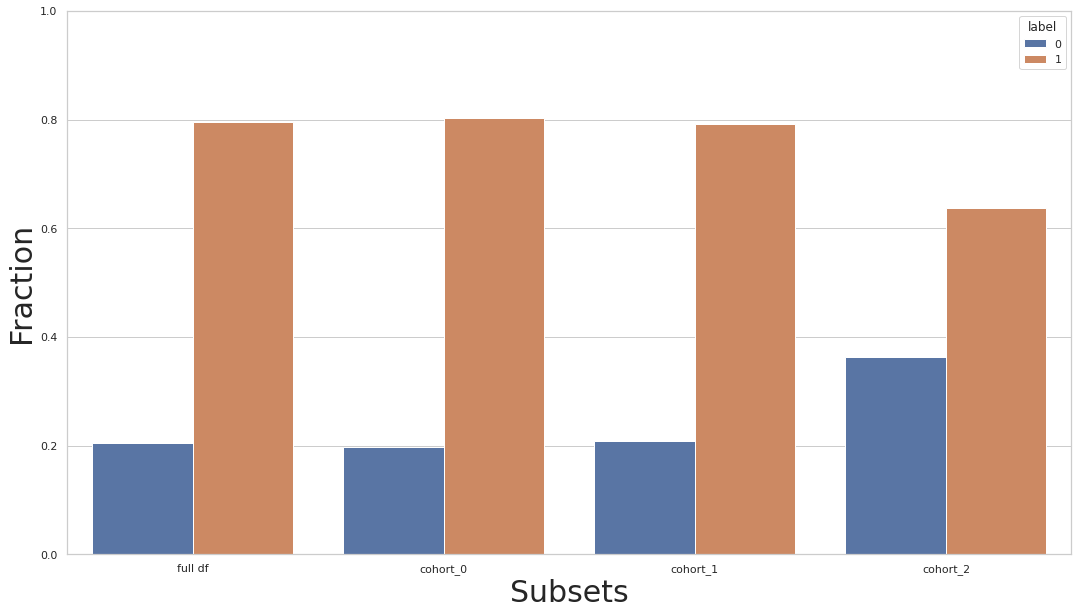

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_value_counts_cohort(y_full, subsets, normalize = True):
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()
    fig = plt.gcf()
    fig.set_size_inches(18, 10)
    sns.set_theme(style="whitegrid")
    if normalize:
        plt.ylim(0, 1)
    #plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=23)

    value_count = y_full.value_counts(normalize=normalize)

    subsets_col = ['full df', 'full df']
    counts_col = [value_count[0], value_count[1]]
    label_col = [0, 1]

    for key in subsets.keys():
        value_count = subsets[key]["y"].value_counts(normalize=normalize)
        subsets_col += [key, key]
        counts_col += [value_count[0], value_count[1]]
        label_col += [0, 1]

    count_df = pd.DataFrame({"subsets":subsets_col, "label":label_col, "counts":counts_col})

    ax = sns.barplot(x="subsets", y="counts", hue="label", data=count_df)
    ax.set_xlabel("Subsets", fontsize=30)
    ax.set_ylabel("Fraction", fontsize=30)
    #ax.tick_params(labelsize=15)
    plt.show()
    
plot_value_counts_cohort(y, subsets, normalize=True)

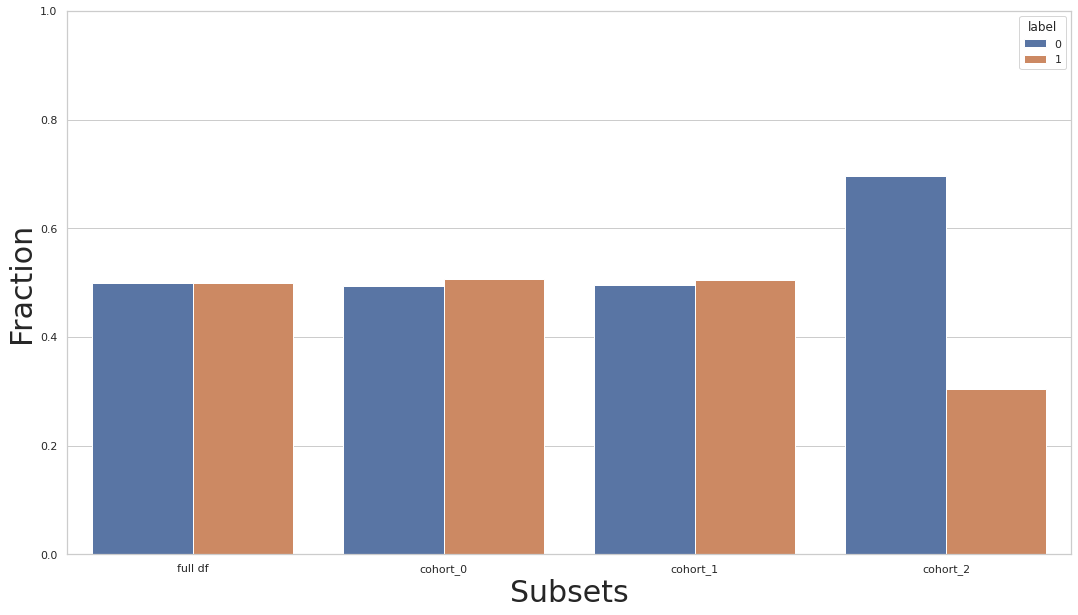

In [ ]:
rebalance = dp.Rebalance(verbose=False)
new_X, new_y = rebalance.fit_resample(X, y)

cohort_set.fit(X=new_X, y=new_y)
subsets = cohort_set.get_subsets(new_X, new_y, apply_transform=False)

plot_value_counts_cohort(new_y, subsets, normalize=True)

label


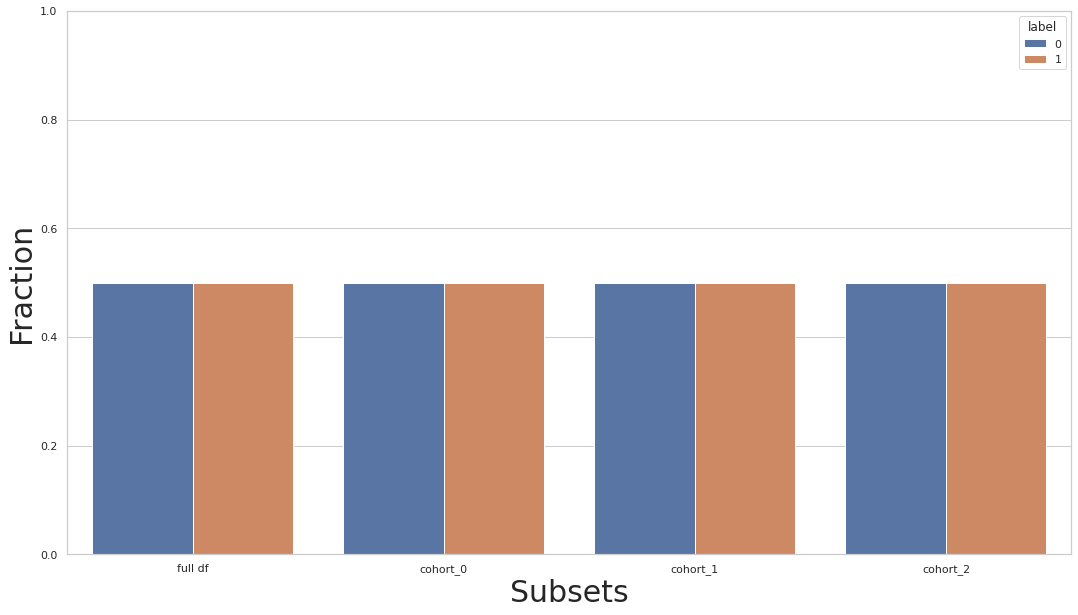

In [ ]:
rebalance_cohort = CohortManager(
    transform_pipe=dp.Rebalance(verbose=False),
    cohort_def=[c1, c2, c3]
)
new_X, new_y = rebalance_cohort.fit_resample(X, y)

subsets = rebalance_cohort.get_subsets(new_X, new_y, apply_transform=False)

plot_value_counts_cohort(new_y, subsets, normalize=True)